In [1]:
import numpy as np
from numpy import r_
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure,plot, title,stem, loglog,xlabel,ylabel
import bitarray, time, urllib, ssl
from scipy import signal, integrate
#from math import gcd
from fractions import gcd
from functools import reduce
from numpy import ones,zeros, pi, cos, exp, sign
from scipy import misc
import serial
import sounddevice as sd
import threading
import time 
import queue
import modulation 
from receiver_thread import *
%matplotlib inline

##Testing the demodder using the tester thread

In [2]:
fs = 48000
baud = 2400
bits = np.array([0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1])
print(len(bits))
test_audio = modulation.afsk1200(bits)
#print(len(test_audio))
bit_length = fs//baud
#print(bit_length)
blocksize = bit_length * 10

27


In [22]:
demod_thread = demodder(1, "demodder")
tester_thread = tester(2, "tester", test_audio, blocksize)

In [23]:
demod_thread.start()
tester_thread.start()
tester_thread.join()
time.sleep(1)
exit_flag = 1

Starting demodder
Starting tester
40
Tester is adding to sound Queue
Got audio chunk! demodding...
80
Tester is adding to sound Queue
Got audio chunk! demodding...
Got audio chunk! demodding...
Got audio chunk! demodding...
Got audio chunk! demodding...
120
Tester is adding to sound Queue
Got audio chunk! demodding...
160
Tester is adding to sound Queue
200
Tester is adding to sound Queue
Got audio chunk! demodding...
Got audio chunk! demodding...
240
Tester is adding to sound Queue
280
Tester is adding to sound Queue
320
Tester is adding to sound Queue
360
Tester is adding to sound Queue
Got audio chunk! demodding...
Got audio chunk! demodding...
Got audio chunk! demodding...
Got audio chunk! demodding...
400
Tester is adding to sound Queue
Got audio chunk! demodding...
440
Tester is adding to sound Queue
480
Tester is adding to sound Queue
520
Tester is adding to sound Queue
Got audio chunk! demodding...
560
Tester is adding to sound Queue
Got audio chunk! demodding...
Got audio chun

/Users/Hersh/Programming/ee123/ee123-proj/baseline/modulation.py:84: RuntimeWarning: overflow encountered in int_scalars
  pll = np.int32(np.int32(pll)+np.int32(tick))


In [24]:
bitstream = serialize_Queue(bitsQueue)

In [25]:
print(len(bitstream))
print(bitstream)

28
[ 0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.]


##Loopback testing of audio receiving, demodding 

In [2]:
#If testing with radio...
# port = serial.Serial('/dev/tty.SLAB_USBtoUART')
# port.setDTR(False)
# time.sleep(1)
# port.setDTR(True)
fs = 48000
baud = 2400
bit_length = fs//baud
blocksize = bit_length * 10
sd.query_devices()

> 0 Built-in Microphone, Core Audio (2 in, 0 out)
< 1 Built-in Output, Core Audio (0 in, 2 out)
  2 HDMI, Core Audio (0 in, 2 out)
  3 USB Audio Device, Core Audio (1 in, 2 out)

In [6]:
usb_idx = 3
stream_queue = stream_receiver(1, "streamer", 2, blocksize)
demod_thread = demodder(2, "demodder")

In [32]:
#Empties the Queues 
while not bitsQueue.empty():
    bitsQueue.get()
while not soundQueue.empty():
    soundQueue.get()   

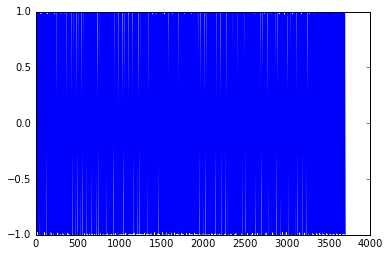

In [14]:
preamble = bitarray.bitarray((np.random.rand(50)>0.5).tolist())
bits = bitarray.bitarray((np.random.rand(100)>0.5).tolist())
lock_seq = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
stop_seq = np.ones(20)
bits_lock = np.concatenate((lock_seq, preamble, bits, stop_seq))
modded_sig = modulation.afsk1200(bits_lock, fc=3000, df=600, baud=baud)
plt.plot(modded_sig)
#sender_thread = transmitter(3, "transmitter", modded_sig, usb_idx, fs, blocksize)

In [16]:
np.save("modded_signal.npy", modded_sig)

In [41]:
#sender_thread.start()
stream_queue.start()
demod_thread.start()
#demod_thread.exit_flag = 1

Starting streamer


In [42]:
stream_queue.exit_flag = 1
demod_thread.exit_flag = 1

In [43]:
rcvd_sig = serialize_Queue(soundQueue)

Exiting streamer


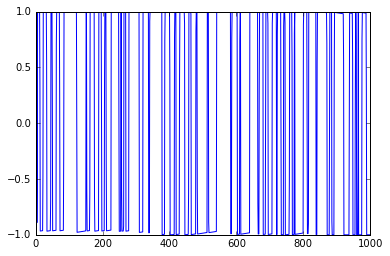

In [44]:
plt.plot(rcvd_sig[100000:101000])
plt.show()

In [45]:
bits, start = modulation.decode_sig(rcvd_sig, preamble, fc=1700, df=500, baud=baud)
print(len(preamble))
print(preamble)
print(len(bits))
print(start)
print(bits[start:start+len(preamble)])

50
bitarray('11101010000100111001000101000100001110110010001011')
7382
449
[1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0
 1 1 1 1 0 0 1 0 1 1 1 0 1]


/Users/Hersh/Programming/ee123/ee123-proj/baseline/modulation.py:84: RuntimeWarning: overflow encountered in int_scalars
  pll = np.int32(np.int32(pll)+np.int32(tick))


In [36]:
bitstream = serialize_Queue(bitsQueue)

In [37]:
start_idx = np.argmax(np.correlate(preamble, bitstream, "same"))
bitstream_real = bitstream[start_idx:]
print(bitstream_real)

[ 1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.  1.  1.  1.
  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
  1.  1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.
  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  0.  1.  0.  0.
  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  1.  0.  1.
  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.
  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  1.  1.  0.  1.  1.  1.
  0.  1.  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.
  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.  1.
  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  1

In [38]:
print(preamble)

bitarray('11111101000001100000001010100111001101111110111000')


In [39]:
print(bitstream)

[ 0.  1.  0.  1.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.
  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.
  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.
  0.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.
  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.
  1.  0.  0.  0.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.
  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  0.
  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.
  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  1.  1

In [16]:
def queueREPLAY_callback(indata,outdata, frames, time, status):
    if status:
        print(status)
    outdata[:] = indata
    soundQueue.put( indata.copy()[:,0] )  # Global queue
    
st_replay = sd.Stream(samplerate=fs, device=usb_idx,callback=queueREPLAY_callback)
Qout = queue.Queue()
Qout.put(modded_sig)

print("Starting streams")
st_replay.start()
demod_thread.start()
starttime = time.time()
while Qout.empty()==False:
    tmp = Qout.get()
    sd.play(0.05*tmp,samplerate=fs,device = 2, blocking=True)
    
st_replay.stop()
st_replay.close()
time.sleep(2)
demod_thread.exit_flag=1

Starting streams
Starting demodder
Got audio chunk! demodding...
Got audio chunk! demodding...


/Users/Hersh/Programming/ee123/ee123-proj/baseline/modulation.py:84: RuntimeWarning: overflow encountered in int_scalars
  pll = np.int32(np.int32(pll)+np.int32(tick))


Exiting demodder


In [17]:
bitstream = serialize_Queue(bitsQueue)

In [18]:
print(preamble)
start_idx = np.argmax(np.correlate(bitstream, preamble, mode = "valid"))
print(bitstream[start_idx:len(preamble)+start_idx])

bitarray('11101100000000101101100011001010010100010100100001')
[ 1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.
  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.
  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.]


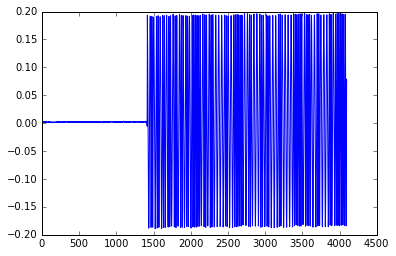

In [47]:
plt.plot(rcv_sig)

In [48]:
bits, start = modulation.decode_sig(rcv_sig, preamble, fc=1700, df=500, baud=baud)
print(bits[start:start+len(preamble)])

[1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1
 0 1 1 0 0 1 0 0 0 1 0 1 1]


/Users/Hersh/Programming/ee123/ee123-proj/baseline/modulation.py:84: RuntimeWarning: overflow encountered in int_scalars
  pll = np.int32(np.int32(pll)+np.int32(tick))


In [4]:
port.setDTR(True)

NameError: name 'port' is not defined

##Testing with radios 

In [20]:
fs = 48000
baud = 1200
fc = 1800
df = 600
blocksize = fs//baud * 10

In [12]:
preamble = bitarray.bitarray((np.random.rand(50)>0.5).tolist())
bits = bitarray.bitarray((np.random.rand(100)>0.5).tolist())
lock_seq = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
stop_seq = np.ones(20)
bits_lock = np.concatenate((lock_seq, preamble, bits, stop_seq))
modded_sig = modulation.afsk1200(bits_lock, fc=fc, df=df, baud=baud)
np.save("modded_signal.npy", modded_sig)

In [30]:
bitsQueue = queue.Queue()
soundQueue = queue.Queue()

def queueREPLAY_callback(indata,outdata, frames, time, status):
    if status:
        print(status)
    outdata[:] = indata
    soundQueue.put( indata.copy()[:,0] )  # Global queue
    
usb_idx = 3
st_replay = sd.Stream(samplerate=fs, device=usb_idx,callback=queueREPLAY_callback)
demod_thread = demodder(2, "demodder", bitsQueue, soundQueue, fc=fc, df=df, baud=baud, fs=fs)

In [31]:
st_replay.start()
demod_thread.start()

Starting demodder


In [32]:
st_replay.stop()
st_replay.close()
demod_thread.exit_flag=1

/Users/Hersh/Programming/ee123/ee123-proj/baseline/modulation.py:84: RuntimeWarning: overflow encountered in int_scalars
  pll = np.int32(np.int32(pll)+np.int32(tick))
/Users/Hersh/Programming/ee123/ee123-proj/baseline/modulation.py:84: RuntimeWarning: overflow encountered in int_scalars
  pll = np.int32(np.int32(pll)+np.int32(tick))


Exiting demodder


In [33]:
bits = serialize_Queue(bitsQueue)

In [34]:
start_idx = np.argmax(np.correlate(bits, preamble, mode="valid"))
bits_preamble = bits[start_idx:start_idx+len(preamble)]
print(bits_preamble)
print(preamble)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.
  0.  1.  1.  1.  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.  0.  0.  0.  1.
  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
bitarray('11011100110111111010011001110011110100111111010001')


In [19]:
print(bits)

[ 0.  0.  0. ...,  1.  1.  1.]


In [39]:
while not bitsQueue.empty():
    bitsQueue.get()
while not soundQueue.empty():
    soundQueue.get()   

In [40]:
rcv_sig = sd.rec(5*fs, samplerate=fs, channels=1, device=usb_idx)
sd.wait()

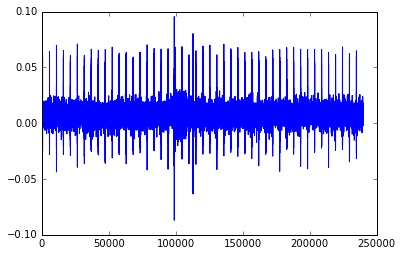

In [41]:
plt.plot(rcv_sig)